Purpose of notebook is to scrape web data on financial asset prices and run a mean-variance optimization framework to target a specific risk-return profile

Import relevant libraries

In [500]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.optimize as sco

Construct URL Generator for given set of securities to import price data

In [501]:
#Provide a dictionary with names and yahoo symbols for securities in portfolio. Be aware the portfolio is assumed to be fully hedged back to base currency!

securities_dictionary ={'S&P 500':'^GSPC',
                        'iShares Global Tech ETF' : 'IXN',
                        'iShares Global Healthcare ETF' : 'IXJ',
                        'FTSE 100' : '^FTSE',
                        'ESTX 50 PR.EUR' : '^STOXX50E',
                        'Nikkei 225' : '^N225',
                        'iShares MSCI Emerging Markets ETF' : 'EEM',
                        'U.S. Treasury Bond Futures' : 'ZB=F',
                        'Vanguard Total World Bond ETF (IG credit)' : 'BNDW',
                        'Gold' : 'GC=F',
                        # 'Crude Oil' : 'CL=F',
                        'Lyxor Core FTSE Actuaries UK Gilts 0-5Y' : 'GIL5.L' }

#Specify frequency of data download eg. daily = '1d' /monthly = '1mo' /weekly = '1wk'

frequency ='1d'

#Specify time window to download data eg. last 30 days and annualisation factor for days

lookback = 2000
ann_factor = 260

#Generates epoch timestamps to construct URL

today_date = dt.datetime(dt.datetime.now().year, dt.datetime.now().month, dt.datetime.now().day-1,1,0,0)
start_date = today_date - dt.timedelta(days=lookback)

today_date_string = str(round(today_date.timestamp()))
start_date_string = str(round(start_date.timestamp()))

#Creates URL dictionary mapping security names to corresponding URL downloads

url_dictionary = {}

for security in securities_dictionary.keys():
    url ='https://query1.finance.yahoo.com/v7/finance/download/'\
         +securities_dictionary[security]+\
         '?period1='+start_date_string\
         +'&period2='+today_date_string\
         +'&interval='+frequency\
         +'&events=history'
    url_dictionary[security] = url


#Display URL dictionary for debugging purposes    
display(url_dictionary)
print('\n')


{'S&P 500': 'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'iShares Global Tech ETF': 'https://query1.finance.yahoo.com/v7/finance/download/IXN?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'iShares Global Healthcare ETF': 'https://query1.finance.yahoo.com/v7/finance/download/IXJ?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'FTSE 100': 'https://query1.finance.yahoo.com/v7/finance/download/^FTSE?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'ESTX 50 PR.EUR': 'https://query1.finance.yahoo.com/v7/finance/download/^STOXX50E?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'Nikkei 225': 'https://query1.finance.yahoo.com/v7/finance/download/^N225?period1=1422925200&period2=1595721600&interval=1d&events=history',
 'iShares MSCI Emerging Markets ETF': 'https://query1.finance.yahoo.com/v7/finance/download/EEM?period1=1422925200&pe

Create a dataframe of daily/weekly/monthly security returns

In [502]:
#Download web data from URL dictionary and store in a dataframe
#Creates a dictionary of dataframes

securities_price_dictionary = {}

for security in url_dictionary.keys():
    #Construct dictionary of dataframes
    securities_price_dictionary[security]=pd.read_csv(url_dictionary[security])
    
    #Select only columns of interest in each dataframe
    securities_price_dictionary[security] = securities_price_dictionary[security][['Date', 'Adj Close']]
    
    #Relabel columns in each dataframe
    securities_price_dictionary[security].columns = ['Date', security+' price level']
    
    #Set dates in each dataframe to Datetime objects
    securities_price_dictionary[security]['Date'] = pd.to_datetime(securities_price_dictionary[security]['Date'])
    
    #Set the index of sub-dataframes to the Date column to help with concatenation
    securities_price_dictionary[security].set_index('Date', inplace=True)

#Concatenate sub-dataframes of dictionary into one main dataframe and set column names

securities_price_df = pd.concat(securities_price_dictionary, axis=1)

securities_price_df.columns= url_dictionary.keys()

col_names = [ name + ' return' for name in url_dictionary.keys()]

#Compute return series and ffill missing values
securities_return_df = securities_price_df.pct_change(fill_method='ffill')
securities_return_df.fillna(0, inplace=True)
securities_return_df = securities_return_df.set_index(securities_price_df.index)
securities_return_df.drop(securities_return_df.index[0], inplace=True)


securities_return_df.columns = col_names

#Print prices and returns dataframes for debugging purposes

display(securities_price_df.head())

display(securities_return_df.tail())

print('\n')


,S&P 500,iShares Global Tech ETF,iShares Global Healthcare ETF,FTSE 100,ESTX 50 PR.EUR,Nikkei 225,iShares MSCI Emerging Markets ETF,U.S. Treasury Bond Futures,Vanguard Total World Bond ETF (IG credit),Gold,Lyxor Core FTSE Actuaries UK Gilts 0-5Y
Date,,,,,,,,,,,
2015-02-03,2050.030029,88.761169,46.409435,6871.799805,3414.179932,17335.849609,35.977200,149.281006,NaN,1259.699951,NaN
2015-02-04,2041.510010,88.827293,45.994820,6860.000000,3415.530029,17678.740234,35.799400,149.438004,NaN,1263.800049,NaN
2015-02-05,2062.520020,89.724731,46.630253,6865.899902,3408.959961,17504.619141,36.012756,148.875000,NaN,1262.000000,NaN
2015-02-06,2055.469971,88.893410,46.130020,6853.399902,3398.159912,17648.500000,35.399361,147.656006,NaN,1233.900024,NaN
2015-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,S&P 500 return,iShares Global Tech ETF return,iShares Global Healthcare ETF return,FTSE 100 return,ESTX 50 PR.EUR return,Nikkei 225 return,iShares MSCI Emerging Markets ETF return,U.S. Treasury Bond Futures return,Vanguard Total World Bond ETF (IG credit) return,Gold return,Lyxor Core FTSE Actuaries UK Gilts 0-5Y return
Date,,,,,,,,,,,
2020-07-20,0.008407,0.024342,0.001662,-0.004578,0.006757,0.000928,0.012859,0.002609,0.000367,0.005026,0.000411
2020-07-21,0.001679,-0.008619,-0.002212,0.001310,0.005020,0.007340,0.009234,0.001041,0.001100,0.014454,0.001095
2020-07-22,0.005747,0.008735,0.005819,-0.009985,-0.010158,-0.005795,-0.004346,0.001213,0.001709,0.011918,-0.000547
2020-07-23,-0.012320,-0.024568,-0.007025,0.000693,0.000291,0.000000,-0.008040,0.003981,0.001218,0.009369,-0.000274
2020-07-24,-0.006190,-0.008630,-0.012207,-0.014103,-0.018047,0.000000,-0.000926,-0.001379,-0.000608,0.007903,-0.000274


Create optimizer inputs: holding period return, risk and covariance matrix

In [503]:
#Calculate a dataframe of return and volatility to use as input to optimizer

optimizer_return_inputs_list = []
optimizer_volatility_inputs_list = []

for security in securities_return_df.columns:
    optimizer_return_inputs_list.append((1+securities_return_df[security]).cumprod()[-1]**(ann_factor/len(securities_return_df))-1)
    optimizer_volatility_inputs_list.append(securities_return_df[security].std()*np.sqrt(ann_factor))

optimizer_inputs_df = pd.DataFrame(zip(optimizer_return_inputs_list, optimizer_volatility_inputs_list))

optimizer_inputs_df.columns = ['Annualised Return', 'Annualised Volatility']
optimizer_inputs_df.index = securities_price_df.columns

#Compute covariance matrix
covariance_matrix = securities_return_df.cov()*ann_factor

#Print optimizer inputs for debugging purposes
display(optimizer_inputs_df)

#Print covariance matrix for debugging purposes
#display(covariance_matrix)




,Annualised Return,Annualised Volatility
S&P 500,0.070886,0.171561
iShares Global Tech ETF,0.163452,0.207309
iShares Global Healthcare ETF,0.067302,0.158541
FTSE 100,-0.017380,0.157417
ESTX 50 PR.EUR,-0.004663,0.185843
Nikkei 225,0.042227,0.188964
iShares MSCI Emerging Markets ETF,0.028008,0.204490
U.S. Treasury Bond Futures,0.029772,0.100651
Vanguard Total World Bond ETF (IG credit),0.022227,0.025690
Gold,0.064546,0.132648


Mean variance portfolio optimizer 

In [504]:
# Define a set of functions to calculate portfolio return, vol and Sharpe ratio. Use optimizer Sharpe ratio and vol functions to find optimal portfolio allocations

def port_ret(weights, returns):
    return np.dot(weights, returns)

def optimizer_port_ret(weights):
    """ Computes portfolio return given a set of weights and assumes a set of security returns defined prior in the script"""
    return port_ret(weights, optimizer_inputs_df['Annualised Return'])

def port_vol(weights, cov_matrix):
    return np.sqrt(np.dot(weights.transpose(), np.dot(cov_matrix, weights)))

def optimizer_port_vol(weights):
    """ Computes portfolio volatility given a set of weights and assumes a covariance matrix defined prior in the script"""
    return port_vol(weights, covariance_matrix)

#Portfolio sharpe is defined as the negative value of the Sharpe ratio in order to make use of the scipy minimize function which will effectively maximize absolute Sharpe ratio
#Assumed risk free rate is 0

def optimizer_port_sharpe(weights):
    return -optimizer_port_ret(weights)/optimizer_port_vol(weights)

#Define optimisation constraints eg. sum of all portfolio weights = 100%
#Boundaries on parameters eg. limit to non-negative values assuming short selling is not permitted

minimum_position_size = 0.00
constraints = ({'type':'eq', 'fun' : lambda x: np.sum(x)-1})
boundaries =tuple((minimum_position_size,1) for x in range(len(securities_dictionary)))

equal_weights = np.array([1/len(securities_dictionary) for int in range(len(securities_dictionary))])

#Use Scip minimize function to minimize optimizer Sharpe function using equal security weights as starting point for optimisation
optimization_result = sco.minimize(optimizer_port_sharpe, equal_weights, method='SLSQP', bounds = boundaries, constraints = constraints)

optimal_portfolio_weights = optimization_result.x
optimal_portfolio_dict =dict(zip(securities_dictionary.keys(), optimal_portfolio_weights.round(2)))
optimal_portfolio_return = optimizer_port_ret(optimal_portfolio_weights)
optimal_portfolio_volatility = optimizer_port_vol(optimal_portfolio_weights)
optimal_portfolio_Sharpe = -1* optimizer_port_sharpe(optimal_portfolio_weights)


display('Optimal portfolio weights', optimal_portfolio_dict)
print('\n')
print('Sum of optimal portfolio weights is ','{0:.2%}'.format(np.sum(optimal_portfolio_weights)))
print('Portfolio return is ', '{0:.2%}'.format(optimal_portfolio_return))
print('Portfolio volatility is ', '{0:.2%}'.format(optimal_portfolio_volatility))
print('Portfolio Sharpe ratio is ', optimal_portfolio_Sharpe.round(2))


'Optimal portfolio weights'

{'S&P 500': 0.0,
 'iShares Global Tech ETF': 0.1,
 'iShares Global Healthcare ETF': 0.0,
 'FTSE 100': 0.0,
 'ESTX 50 PR.EUR': 0.0,
 'Nikkei 225': 0.01,
 'iShares MSCI Emerging Markets ETF': 0.0,
 'U.S. Treasury Bond Futures': 0.07,
 'Vanguard Total World Bond ETF (IG credit)': 0.75,
 'Gold': 0.07,
 'Lyxor Core FTSE Actuaries UK Gilts 0-5Y': 0.0}



Sum of optimal portfolio weights is  100.00%
Portfolio return is  4.02%
Portfolio volatility is  3.31%
Portfolio Sharpe ratio is  1.21


Display Minimum Variance Frontier and Optimal Portfolio for Given Level of Return

'Custom portfolio weights '

{'S&P 500': 0.0,
 'iShares Global Tech ETF': 0.15,
 'iShares Global Healthcare ETF': 0.0,
 'FTSE 100': 0.0,
 'ESTX 50 PR.EUR': 0.0,
 'Nikkei 225': 0.01,
 'iShares MSCI Emerging Markets ETF': 0.0,
 'U.S. Treasury Bond Futures': 0.09,
 'Vanguard Total World Bond ETF (IG credit)': 0.65,
 'Gold': 0.1,
 'Lyxor Core FTSE Actuaries UK Gilts 0-5Y': 0.0}



Custom portfolio return is 4.82%
Custom portfolio volatility is 4.05%
Custom portfolio Sharpe is 1.19
Sum of custom portfolio weights is 100.00%


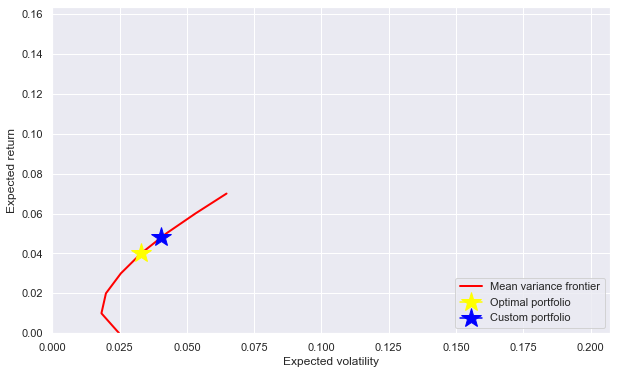

In [505]:
#State constraints and boundaries for mean-variance frontier portfolios

frontier_constrains = ({'type' : 'eq', 'fun' : lambda x: np.sum(x)-1},
                       {'type' : 'eq', 'fun' : lambda x: optimizer_port_ret(x) - tret})

boundaries = tuple((minimum_position_size,1) for x in range(len(securities_dictionary)))

#Set range of target returns around optimal portfolio using a scaling factor
scaling_factor = 0.7
step_size = 0.01
trets =np.arange((optimal_portfolio_return *(1-scaling_factor)).round(1), (optimal_portfolio_return*(1+scaling_factor)).round(2), step_size)

#Construct minimum variance frontier by finding the volatility corresponding to teach target return
tvols = []

for tret in trets:
    res = sco.minimize(optimizer_port_vol, equal_weights, method = 'SLSQP', bounds = boundaries, constraints = frontier_constrains)
    tvols.append(res['fun'])

tvols=np.array(tvols)

#User specified target return. Optimizer returns custom portfolio weights to achieve target return
tret = optimal_portfolio_return * 1.2


custom_optimization = sco.minimize(optimizer_port_vol, equal_weights, method = 'SLSQP', bounds = boundaries, constraints = frontier_constrains)
custom_portfolio_dict = dict(zip(securities_dictionary.keys(), custom_optimization.x.round(2)))
custom_portfolio_weights = custom_optimization.x

#Print custom portfolio statistics

display('Custom portfolio weights ', custom_portfolio_dict)

print('\n')
print('Custom portfolio return is', '{0:.2%}'.format(tret))
print('Custom portfolio volatility is', '{0:.2%}'.format(optimizer_port_vol(custom_optimization.x)))
print('Custom portfolio Sharpe is', -1*optimizer_port_sharpe(custom_optimization.x).round(2))
print('Sum of custom portfolio weights is', '{0:.2%}'.format(custom_portfolio_weights.sum()))

#Display mean variance frontier, optimal portfolio and custom portfolio
sns.set()

plt.figure(figsize=(10, 6))
plt.plot(tvols, trets, 'r', lw=2.0, color='red', label='Mean variance frontier')
plt.plot(optimal_portfolio_volatility, optimal_portfolio_return, marker='*', color='yellow', markersize=20, label='Optimal portfolio')
plt.plot(optimizer_port_vol(custom_optimization.x), tret, marker='*', color='blue', markersize=20, label='Custom portfolio')
plt.ylim(0.0 , optimizer_inputs_df['Annualised Return'].max())
plt.xlim(0.0 , optimizer_inputs_df['Annualised Volatility'].max())
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.legend(loc = 'lower right')

plt.show()


Backtest optimizer against a set of benchmarks

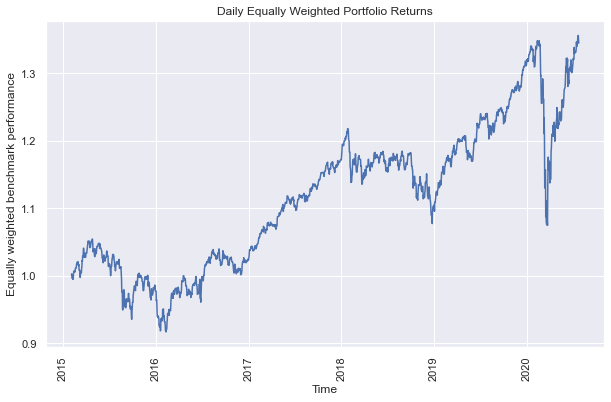

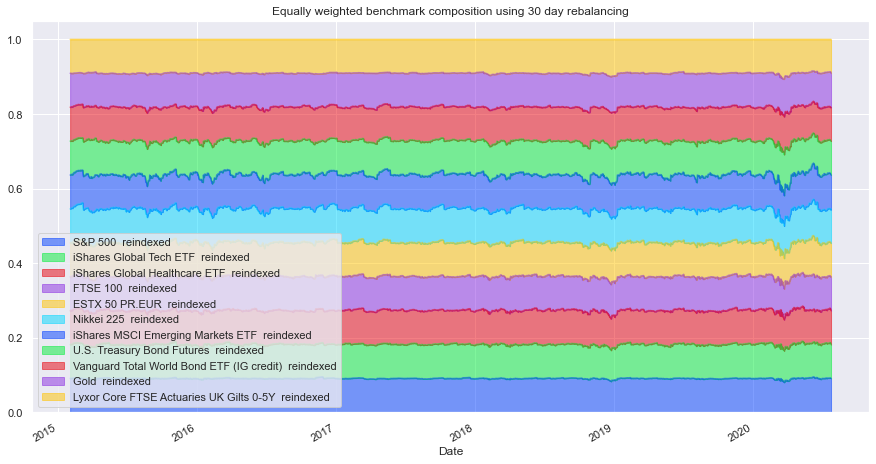

In [512]:
#Create a backtest benchmark using an equally weighted portfolio

#Specify rebalance period eg 5 days
rebalance_period = 30

#Construct a dataframe of drifted benchmark weights
equal_weights_index =[1 for x in enumerate(securities_return_df.columns)]
start_index_df = pd.DataFrame(equal_weights_index).transpose()
start_index_df.columns = securities_return_df.columns
start_index_df['Date'] = securities_price_df.index[0]
start_index_df.set_index('Date', inplace=True)

drift_index_df = pd.concat([start_index_df, securities_return_df])

drifted_col_names = [name.strip('return')+' reindexed' for name in drift_index_df.columns]
drift_index_df.columns = drifted_col_names

for day in drift_index_df.index:
    if drift_index_df.loc[:day,'S&P 500  reindexed'].count() % rebalance_period == 0:
        drift_index_df.loc[day] = 1

for day in drift_index_df.index:
    if drift_index_df.loc[day].sum() != drift_index_df.shape[1]:
        location = drift_index_df.index.get_loc(day)
        index_array = np.array(drift_index_df.iloc[location - 1])
        returns_array = np.array(1+securities_return_df.iloc[location-1])
        drift_index_df.loc[day] = index_array * returns_array

drift_index_df['Levels sum'] = drift_index_df.sum(axis='columns')

drift_weights_df = pd.DataFrame()

for col in drift_index_df.columns:
    drift_weights_df[col] = np.divide(drift_index_df[col], drift_index_df['Levels sum'])

drift_weights_df.drop(['Levels sum'], axis=1, inplace=True)

# Shift returns dataframe by 1 day to account for timing differences
zeroes_df = pd.DataFrame(np.full((1,drift_weights_df.shape[1]), 0))
zeroes_df.columns = securities_return_df.columns
zeroes_df['Date'] = securities_price_df.index[-1]
zeroes_df.set_index('Date', inplace=True)

reindexed_securities_return_df = securities_return_df.append(zeroes_df)

# Compute benchmark return as the dot product of the drifted weights and the securities return. Drop last record to account for the offset in returns

equal_portfolio_returns_df = np.multiply(reindexed_securities_return_df,drift_weights_df)

equal_portfolio_returns_df = equal_portfolio_returns_df.loc[~equal_portfolio_returns_df.index.duplicated(keep='first')]

equal_portfolio_returns_df['Equal weighted portfolio return'] = equal_portfolio_returns_df.sum(axis='columns')

#display(drift_weights_df.tail())
#display(reindexed_securities_return_df.tail())
#display(equal_portfolio_returns_df.tail())

# Plot benchmark returns

sns.set()
plt.figure(figsize=(10, 6))
plt.plot(equal_portfolio_returns_df.index, np.cumprod(1+equal_portfolio_returns_df['Equal weighted portfolio return']))
plt.xticks(rotation=90)
plt.title('Daily Equally Weighted Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Equally weighted benchmark performance')
plt.show()

#Plot drifted benchmark weights
plt.style.use('seaborn-bright')
drift_weights_df.plot.area(legend=False, alpha=0.5, figsize=(15,8))
plt.title('Equally weighted benchmark composition using '+ str(rebalance_period) + ' day rebalancing')
plt.legend(loc = 'lower left')
plt.show()
